# Working with Order Book Data: NASDAQ ITCH

The primary source of market data is the order book, which is continuously updated in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service and may provide some historical data for free.

The trading activity is reflected in numerous messages about trade orders sent by market participants. These messages typically conform to the electronic Financial Information eXchange (FIX) communications protocol for real-time exchange of securities transactions and market data or a native exchange protocol. 

## Background

### The FIX Protocol

Just like SWIFT is the message protocol for back-office (example, for trade-settlement) messaging, the [FIX protocol](https://www.fixtrading.org/standards/) is the de facto messaging standard for communication before and during, trade execution between exchanges, banks, brokers, clearing firms, and other market participants. Fidelity Investments and Salomon Brothers introduced FIX in 1992 to facilitate electronic communication between broker-dealers and institutional clients who by then exchanged information over the phone.

It became popular in global equity markets before expanding into foreign exchange, fixed income and derivatives markets, and further into post-trade to support straight-through processing. Exchanges provide access to FIX messages as a real-time data feed that is parsed by algorithmic traders to track market activity and, for example, identify the footprint of market participants and anticipate their next move. 

### Nasdaq TotalView-ITCH Order Book data

While FIX has a dominant large market share, exchanges also offer native protocols. The Nasdaq offers a [TotalView ITCH direct data-feed protocol](http://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHspecification.pdf) that allows subscribers to track 
individual orders for equity instruments from placement to execution or cancellation.

As a result, it allows for the reconstruction of the order book that keeps track of the list of active-limit buy and sell orders for a specific security or financial instrument. The order book reveals the market depth throughout the day by listing the number of shares being bid or offered at each price point. It may also identify the market participant responsible for specific buy and sell orders unless it is placed anonymously. Market depth is a key indicator of liquidity and the potential price impact of sizable market orders. 

The ITCH v5.0 specification declares over 20 message types related to system events, stock characteristics, the placement and modification of limit orders, and trade execution. It also contains information about the net order imbalance before the open and closing cross.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

## Get NASDAQ ITCH Data from FTP Server

The Nasdaq offers [samples](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/) of daily binary files for several months. 

We are now going to illustrates how to parse a sample file of ITCH messages and reconstruct both the executed trades and the order book for any given tick.

The data is fairly large and running the entire example can take a lot of time and require substantial memory (16GB+). Also, the sample file used in this example may no longer be available because NASDAQ occasionaly updates the sample files.

The following table shows the frequency of the most common message types for the sample file date March 29, 2018:

| Name                    | Offset  | Length  | Value      | Notes                                                                                |
|-------------------------|---------|---------|------------|--------------------------------------------------------------------------------------|
| Message Type            | 0       | 1       | S          | System Event Message                                                                 |
| Stock Locate            | 1       | 2       | Integer    | Always 0                                                                             |
| Tracking Number         | 3       | 2       | Integer    | Nasdaq internal tracking number                                                      |
| Timestamp               | 5       | 6       | Integer    | Nanoseconds since midnight                                                           |
| Order Reference Number  | 11      | 8       | Integer    | The unique reference number assigned to the new order at the time of receipt.        |
| Buy/Sell Indicator      | 19      | 1       | Alpha      | The type of order being added. B = Buy Order. S = Sell Order.                        |
| Shares                  | 20      | 4       | Integer    | The total number of shares associated with the order being added to the book.        |
| Stock                   | 24      | 8       | Alpha      | Stock symbol, right padded with spaces                                               |
| Price                   | 32      | 4       | Price (4)  | The display price of the new order. Refer to Data Types for field processing notes.  |
| Attribution             | 36      | 4       | Alpha      | Nasdaq Market participant identifier associated with the entered order               |

### Set Data paths

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [5]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

You can find several sample files on the [NASDAQ server](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/).

The HTTPS address, filename and corresponding date used in this example:

In [2]:
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/Nasdaq ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

#### URL updates

NASDAQ updates the files occasionally so that the SOURCE_FILE changes. If the above gives an error, navigate to the HTTPS_URL using your browser, and check for new files. As of September 2021, the listed files include:

- 01302020.NASDAQ_ITCH50.gz
- 12302019.NASDAQ_ITCH50.gz
- 10302019.NASDAQ_ITCH50.gz
- 08302019.NASDAQ_ITCH50.gz
- 07302019.NASDAQ_ITCH50.gz
- 03272019.NASDAQ_ITCH50.gz
- 01302019.NASDAQ_ITCH50.gz
- 12282018.NASDAQ_ITCH50.gz


### Download & unzip

In [7]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    else: 
        print('Directory exists')

    filename = data_path / url.split('/')[-1]        
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    else: 
        print('File exists')        

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else: 
        print('File already unpacked')
    return unzipped

This will download 5.1GB data that unzips to 12.9GB (this may vary depending on the file, see 'url updates' below).

In [8]:
file_name = may_be_download(urljoin(FTP_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Directory exists
Downloading... ftp://emi.nasdaq.com/ITCH/Nasdaq ITCH/10302019.NASDAQ_ITCH50.gz
Unzipping to data/10302019.NASDAQ_ITCH50.bin


## ITCH Format Settings

### The `struct` module for binary data

The ITCH tick data comes in binary format. Python provides the `struct` module (see [docs](https://docs.python.org/3/library/struct.html)) to parse binary data using format strings that identify the message elements by indicating length and type of the various components of the byte string as laid out in the specification.

From the docs:

> This module performs conversions between Python values and C structs represented as Python bytes objects. This can be used in handling binary data stored in files or from network connections, among other sources. It uses Format Strings as compact descriptions of the layout of the C structs and the intended conversion to/from Python values.

Let's walk through the critical steps to parse the trading messages and reconstruct the order book:

### Defining format strings

The parser uses format strings according to the following formats dictionaries:

In [9]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [10]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [11]:
formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s',  # int of length 6 => parse as string, convert later
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

### Create message specs for binary data parser

The ITCH parser relies on message specifications that we create in the following steps.

#### Load Message Types

The file `message_types.xlxs` contains the message type specs as laid out in the [documentation](https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHSpecification.pdf)

In [14]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

In [15]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


#### Basic Cleaning

The function `clean_message_types()` just runs a few basic string cleaning steps.

In [16]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [17]:
message_types = clean_message_types(message_data)

#### Get Message Labels

We extract message type codes and names so we can later make the results more readable.

In [18]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


### Finalize specification details

Each message consists of several fields that are defined by offset, length and type of value. The `struct` module will use this format information to parse the binary source data.

In [19]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


In [20]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


Optionally, persist/reload from file:

In [21]:
message_types.to_csv('message_types.csv', index=False)

In [22]:
message_types = pd.read_csv('message_types.csv')

The parser translates the message specs into format strings and `namedtuples` that capture the message content. First, we create `(type, length)` formatting tuples from ITCH specs:

In [23]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))

Then, we extract formatting details for alphanumerical fields

In [24]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

We generate message classes as named tuples and format strings

In [25]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

In [26]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [27]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


Fields of `alpha` type (alphanumeric) require post-processing as defined in the `format_alpha` function:

In [28]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

## Process Binary Message Data

The binary file for a single day contains over 350,000,000 messages worth over 12 GB.

In [29]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            try:
                store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0

In [30]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

The script appends the parsed result iteratively to a file in the fast HDF5 format using the `store_messages()` function we just defined to avoid memory constraints (see last section in chapter 2 for more on this format).

The following code processes the binary file and produces the parsed orders stored by message type:

In [31]:
start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')        
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])
        
        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))


 Start of Messages
	03:02:31.65	           0

 Start of System Hours
	04:00:00.00	     241,258

 Start of Market Hours
	09:30:00.00	   9,559,279
	09:44:09.23	  25,000,000	00:01:02.00
	10:07:45.15	  50,000,000	00:03:44.70
	10:39:56.24	  75,000,000	00:06:16.47
	11:18:09.64	 100,000,000	00:08:39.93
	11:58:35.35	 125,000,000	00:11:00.63
	12:44:20.61	 150,000,000	00:13:32.31
	13:41:03.75	 175,000,000	00:16:08.89
	14:18:44.52	 200,000,000	00:18:51.11
	14:49:19.38	 225,000,000	00:21:22.27
	15:19:40.72	 250,000,000	00:23:56.65
	15:50:23.01	 275,000,000	00:26:33.00

 End of Market Hours
	16:00:00.00	 290,920,164

 End of System Hours
	20:00:00.00	 293,944,863

 End of Messages
	20:05:00.00	 293,989,078
Duration: 00:30:09.81


## Summarize Trading Day

### Trading Message Frequency

In [32]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

,Message Type,# Trades
A,add_order_no_mpid_attribution,127214649
D,order_delete,123296742
U,order_replace,25513651
E,order_executed,7316703
I,noii,3740140
X,order_cancel,3568735
P,trade,1525363
F,add_order_mpid_attribution,1423908
L,market_participant_position,214865
C,order_executed_with_price,129729


In [33]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

### Top Equities by Traded Value

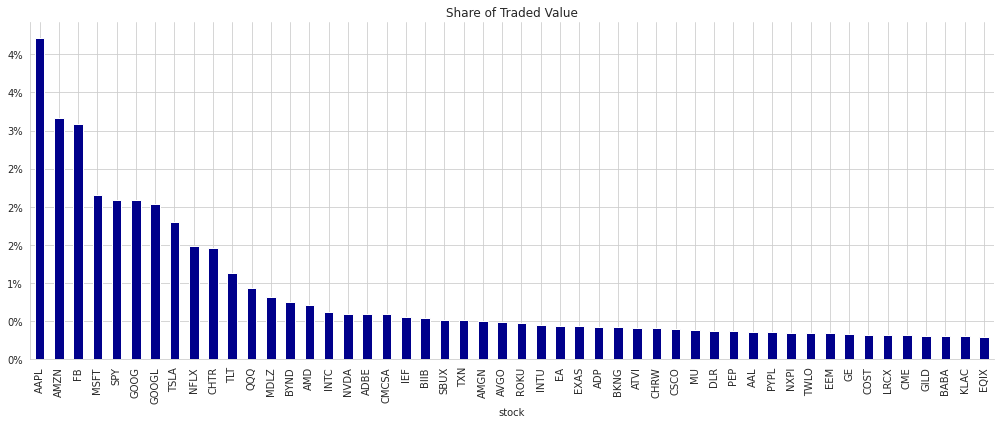

In [34]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()